# Common link
* [Load Data](#load-data)
* [Split Data](#split-dataset)
* [Model](#model)
* [Evaluation](#evaluation)

In [1]:
feature = 29
RAT = 10

# Model

In [2]:
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from sklearn.ensemble import IsolationForest
import numpy as np

model = None

def define_IF(ratio):
    return IsolationForest(contamination = ratio, random_state = 1)

# Training

In [3]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [4]:
def train(x_train):
    # Training the model
    model.fit(x_train)

# Evaluation

In [5]:
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

TPR_res, FPR_res, P_res, R_res = [], [], [], []
AUC_res, AUPRC_res = [], []
accuracies, fscore_res, recall_res, precision_res = [], [], [], []
reports = []
scores = []
THR_opt = []

def evaluation(x_test,y_test):
    
    score = -model.decision_function(x_test)
    fpr, tpr, threshold_auc = roc_curve(y_score=score, y_true=y_test, pos_label=1)
    TPR_res.append(tpr)
    FPR_res.append(fpr)
    precision, recall, threshold_prc = precision_recall_curve(probas_pred=score, y_true=y_test, pos_label=1)
    P_res.append(precision)
    R_res.append(recall)

    auc_score = auc(fpr,tpr)
    auprc_score = auc(recall, precision)
    AUC_res.append(auc_score)
    AUPRC_res.append(auprc_score)


    # optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low.
    J = tpr - fpr
    ix1 = np.argmax(J)
    optimal_threshold = threshold_auc[ix1]
    #optimal_threshold = sorted(list(zip(np.sqrt(tpr-fpr), threshold_auc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUC:',optimal_threshold, 'TPR-FPR=',J[ix1])

    fscore = (2 * precision * recall) / (precision + recall)
    ix2 = np.nanargmax(fscore)
    optimal_prc_threshold = threshold_prc[ix2]
    #optimal_prc_threshold = sorted(list(zip(np.abs(precision - recall), threshold_prc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUPRC:',optimal_prc_threshold,'f-score=', fscore[ix2])
    
    fscore_res.append(fscore[ix2])
    recall_res.append(recall[ix2])
    precision_res.append(precision[ix2])

    THR_opt.append({'AUC':optimal_threshold, 'PRC':optimal_prc_threshold})
    
    yTest_predict = [0 if s<=optimal_prc_threshold else 1 for s in score]
    class_report = classification_report(y_pred=yTest_predict, y_true=y_test, digits=4, output_dict=True)
    reports.append(class_report)
    accuracies.append(class_report['accuracy'])


# K-Fold Train

In [6]:
TOTAL_RUN = 10
run = 1

for run in range(1,TOTAL_RUN+1):
    print('run: {!r}'.format(run))
    datasets = np.load('data/Runs/{!s}_{!s}_Runs/Run_{!s}.npz'.format(RAT,TOTAL_RUN, run))
    x_train, y_train = datasets['trainX'], datasets['trainY']
    x_test, y_test = datasets['testX'], datasets['testY']
    print('train:',x_train.shape,y_train.shape,'; ','test:',x_test.shape,y_test.shape)
    
    # For Isolation Forest Model
    ratio = float(y_test[y_test==1].shape[0]/(y_test[y_test==1].shape[0]+y_test[y_test==0].shape[0]))
    model = define_IF(ratio)
    
    train(x_train=x_train)
    evaluation(x_test=x_test, y_test=y_test)
    run+=1

run: 1
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.016864914393486197 TPR-FPR= 0.8036585365853659
Optimal threshold for best AUPRC: 0.0520524925466026 f-score= 0.7573182247403211
run: 2
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.016925693652067086 TPR-FPR= 0.8199186991869918
Optimal threshold for best AUPRC: 0.0579604175194357 f-score= 0.7901960784313725
run: 3
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.015501742461113077 TPR-FPR= 0.8201219512195121
Optimal threshold for best AUPRC: 0.06633452206583085 f-score= 0.7881188118811882
run: 4
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)


<ipython-input-5-bace2ebc9cfe>:38: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Optimal threshold for best AUC: 0.017073259269754226 TPR-FPR= 0.8154471544715447
Optimal threshold for best AUPRC: 0.05714396454264392 f-score= 0.8099999999999999
run: 5
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.022075924826190307 TPR-FPR= 0.8138211382113821
Optimal threshold for best AUPRC: 0.06600041738284707 f-score= 0.7898989898989899
run: 6
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.030962207993350477 TPR-FPR= 0.8105691056910569
Optimal threshold for best AUPRC: 0.06333054171339603 f-score= 0.7898832684824902
run: 7
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)


<ipython-input-5-bace2ebc9cfe>:38: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Optimal threshold for best AUC: 0.015548026284282257 TPR-FPR= 0.7975609756097561
Optimal threshold for best AUPRC: 0.06402673002429399 f-score= 0.7767944936086529
run: 8
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)
Optimal threshold for best AUC: 0.030849050319022964 TPR-FPR= 0.800609756097561
Optimal threshold for best AUPRC: 0.06229114760959131 f-score= 0.7721021611001965
run: 9
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)


<ipython-input-5-bace2ebc9cfe>:38: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Optimal threshold for best AUC: 0.038627089719851626 TPR-FPR= 0.8
Optimal threshold for best AUPRC: 0.06380697897612819 f-score= 0.7555988315481986
run: 10
train: (279395, 29) (279395,) ;  test: (5412, 29) (5412,)


<ipython-input-5-bace2ebc9cfe>:38: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Optimal threshold for best AUC: 0.00894703231684657 TPR-FPR= 0.816869918699187
Optimal threshold for best AUPRC: 0.07358687698313349 f-score= 0.7730426164519325


<ipython-input-5-bace2ebc9cfe>:38: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


# Retrain
* [back to model](#model)

# AUC and PR curve

0.5


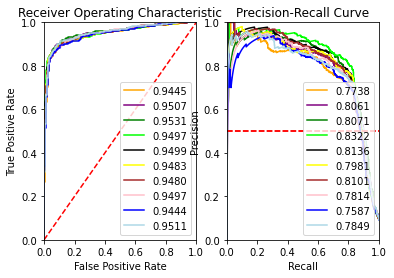

Average AUC score =  0.9489396605856303
Average AUPRC score =  0.79659492354643
Average f1 score =  0.7802953476143342
Average recall =  0.8069105691056911
Average precision =  0.7557790645127993
Average accuracy =  0.9584626755358462
[{'AUC': 0.016864914393486197, 'PRC': 0.0520524925466026}, {'AUC': 0.016925693652067086, 'PRC': 0.0579604175194357}, {'AUC': 0.015501742461113077, 'PRC': 0.06633452206583085}, {'AUC': 0.017073259269754226, 'PRC': 0.05714396454264392}, {'AUC': 0.022075924826190307, 'PRC': 0.06600041738284707}, {'AUC': 0.030962207993350477, 'PRC': 0.06333054171339603}, {'AUC': 0.015548026284282257, 'PRC': 0.06402673002429399}, {'AUC': 0.030849050319022964, 'PRC': 0.06229114760959131}, {'AUC': 0.038627089719851626, 'PRC': 0.06380697897612819}, {'AUC': 0.00894703231684657, 'PRC': 0.07358687698313349}]


In [7]:
rcParams['figure.figsize'] = 20, 5
#plot
fig, ax=plt.subplots(1,2)
proportion_of_abn = 0.5

colors = ['orange','purple','green','lime','black','yellow','brown','pink','blue','lightblue']
print(proportion_of_abn)


for i in range(len(TPR_res)):
    tpr, fpr = TPR_res[i], FPR_res[i]
    precision, recall = P_res[i], R_res[i]
    auc_score, auprc_score = AUC_res[i], AUPRC_res[i]
    indicator = colors[i]

    #ROC curve
    ax[0].plot(fpr, tpr, color = indicator, label = '%0.4f' % auc_score)
    ax[0].legend(loc = 'lower right')

    #PR curve
    ax[1].plot(recall, precision, color = indicator, label='%0.4f' % auprc_score)
    ax[1].legend(loc = 'lower right')
    


ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].set_title('Precision-Recall Curve')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
plt.show()

#calculate average AUC and AUPRC score
print('Average AUC score = ',sum(AUC_res) / TOTAL_RUN)
print('Average AUPRC score = ',sum(AUPRC_res) / TOTAL_RUN)
print('Average f1 score = ',sum(fscore_res) / TOTAL_RUN)
print('Average recall = ',sum(recall_res) / TOTAL_RUN)
print('Average precision = ',sum(precision_res) / TOTAL_RUN)
print('Average accuracy = ', sum(accuracies)/TOTAL_RUN)

print(THR_opt)

#print optnimal thresholds of 10 folds
#print(THR_opt)

In [11]:
TPR_maxlen = FPR_maxlen = P_maxlen = R_maxlen = 0

for i in range(len(TPR_res)):
    if TPR_maxlen < len(TPR_res[i]): TPR_maxlen = len(TPR_res[i])
    if FPR_maxlen < len(FPR_res[i]): FPR_maxlen = len(FPR_res[i])
    if P_maxlen < len(P_res[i]): P_maxlen = len(P_res[i])
    if R_maxlen < len(R_res[i]): R_maxlen = len(R_res[i])

def AddOn(addTo,data,row, dataLen):
    tmp = data[0]
    for i in range(dataLen):
        if i<len(data[row]) and data[row][i] is not np.nan: tmp = data[row][i]
        addTo[i]+=tmp

def AVG(data):
    return (data / TOTAL_RUN).tolist()
TPR_avg, FPR_avg, P_avg, R_avg = np.zeros((TPR_maxlen)), np.zeros((FPR_maxlen)), np.zeros((P_maxlen)), np.zeros((R_maxlen))

for i in range(len(TPR_res)):
    AddOn(TPR_avg, TPR_res, i, TPR_maxlen)
    AddOn(FPR_avg, FPR_res, i, FPR_maxlen)
    AddOn(P_avg, P_res, i, P_maxlen)
    AddOn(R_avg, R_res, i, R_maxlen)
    
TPR_avg, FPR_avg, P_avg, R_avg = AVG(TPR_avg), AVG(FPR_avg), AVG(P_avg), AVG(R_avg)

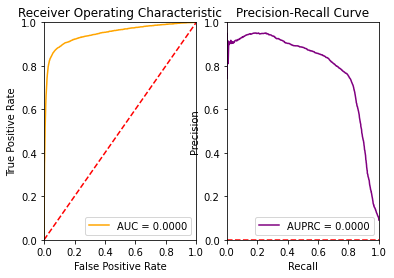

In [12]:
#plot
fig, ax=plt.subplots(1,2)

#ROC curve
ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot(FPR_avg, TPR_avg, color = 'orange', label = 'AUC = %0.4f' % 0)
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

#PR curve
ax[1].set_title('Precision-Recall Curve')
ax[1].plot(R_avg, P_avg, color = 'purple', label='AUPRC = %0.4f' % 0)
ax[1].legend(loc = 'lower right')
nScore, abnScore = y_test[y_test==1], y_test[y_test==-1]
proportion_of_abn = len(abnScore) / (len(nScore)+len(abnScore))
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')

plt.show()

# Save Result to json

In [13]:
import json

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), "r", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), 'w', encoding='utf-8') as jsonFile:
    data['IF'] = {
            'AUC': AUC_res,
            'AUPRC': AUPRC_res,
            'Fscore': fscore_res,
            'Recall': recall_res,
            'Precision': precision_res,
            'Accuracy': accuracies,
            'THR_opt': THR_opt,
            'AVG': {
                'TPR': TPR_avg,
                'FPR': FPR_avg,
                'P': P_avg,
                'R': R_avg
            }
        }
    
    json.dump(data, jsonFile, ensure_ascii=False)

# End of Jupyter
* [To top](#common-link)